Accessing Remote Resources & Bayesian statistics
============================

Web pages and data
------------------

I have mentioned before how one can access data files on your hard drive, but Python also allows you to access remote data, for example on the internet. The easiest way to do this is to use the [requests](https://pypi.python.org/pypi/requests) module. To start off, you just can get the URL (e.g. http://xkcd.com/353/):

In [1]:
import requests

response = requests.get('http://xkcd.com/353/')

``response`` holds the response now. You can access the content as text via the text-property:

In [2]:
print(response.text[:300])  # only print the first 300 characters

<!DOCTYPE html>
<html>
<head>
<link rel="stylesheet" type="text/css" href="/s/7d94e0.css" title="Default"/>
<title>xkcd: Python</title>
<meta http-equiv="X-UA-Compatible" content="IE=edge"/>
<link rel="shortcut icon" href="/s/919f27.ico" type="image/x-icon"/>
<link rel="icon" href="/s/919f27.ico" ty


You can either just use this information directly, or in some cases you might want to write it to a file. Let's download the contour of our world.

In [3]:
r2 = requests.get('http://www.gnuplotting.org/data/world_50m.txt')

In [4]:
r2.headers

{'Date': 'Fri, 24 Feb 2023 08:04:25 GMT', 'Content-Type': 'text/plain', 'Content-Length': '2167953', 'Connection': 'keep-alive', 'Server': 'Apache', 'Last-Modified': 'Wed, 09 Jan 2013 18:49:07 GMT', 'ETag': '"211491-4d2df845beec0"', 'Accept-Ranges': 'bytes'}

In [5]:
r2.content[:100]
with open('world.dat','wb') as fl:
    fl.write(r2.content)

Let's now load and plot the data:

In [6]:
import numpy as np
datax,datay = np.loadtxt('world.dat',unpack=True)

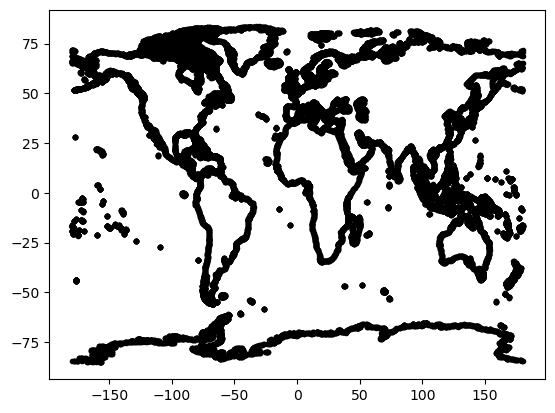

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(datax,datay,marker='.',lw=0,color='k')

APIs
----

Imagine that you want to access some data online. 
A number of websites now offer an "Application programming interface" (or API) which is basically a way of accessing data in a machine-readable way. 
An example for weather data is http://openweathermap.org/API 

For the access, we often need an access key. This is usually generated for you, e.g. if you want to access cloud services of one of the well-known providers. The following examples tells you how that can be added.

In [8]:
#headers={"api-key":"964c07877e903a170986734b5c36a012"}

In [9]:
import requests
r = requests.get('http://samples.openweathermap.org/data/2.5/weather?lat=35&lon=139&appid=b6907d289e10d714a6e88b30761fae22')#, headers=headers) if you need a token
print (r.text[:500])

{"coord":{"lon":139.01,"lat":35.02},"weather":[{"id":800,"main":"Clear","description":"clear sky","icon":"01n"}],"base":"stations","main":{"temp":285.514,"pressure":1013.75,"humidity":100,"temp_min":285.514,"temp_max":285.514,"sea_level":1023.22,"grnd_level":1013.75},"wind":{"speed":5.52,"deg":311},"clouds":{"all":0},"dt":1485792967,"sys":{"message":0.0025,"country":"JP","sunrise":1485726240,"sunset":1485763863},"id":1907296,"name":"Tawarano","cod":200}


Another example of an organization that provides access to its (cloud based) archives via API is the Las Cumbres Observatory (LCO) which provides access to millions of astronomical images. Querying and downloading files requires python scripts if one wants to automatically search the archive. Scientific users are then provided with instruction on how to us the interface:

https://developers.lco.global/#data-format-definition



Saving and restoring data efficiently
----------------------------------------------

As we have seen before, there are multiple ways of opening and processing data. You can, of course, always resort to writing data line by line to disk. In practice, there are multiple alternatives for writing python data to disk and some of them are actually more efficient than others.

First of all, when you are working with numpy arrays and structures you might want to consider using built-in function such as np.savetext

### .npy datafiles

In [10]:
# example from https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html
x = y = z = np.arange(0.0,5.0,1.0)
np.savetxt('test.out', x, delimiter=',')   # X is an array
np.savetxt('test.out', (x,y,z))   # x,y,z equal sized 1D arrays

Sometimes one wants to restore the exact, current state of a numpy array without actually writing all human-readable digits to disk. In order to achieve that, numpy comes with a dedicated numpy.save method. It permits to store the actual bits efficiently to disk without having to waste characters for doing that. 

In [11]:
x = np.arange(10)
with open('test.npy','wb') as fp:
    np.save(fp,x)
    
print(x)
with open('test.npy','rb') as fp2:
    y = np.load(fp2)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


### Pickle datafiles

Sometimes, however, you want to save more complex datasets to a file. The module `pickle` lets you do this. Pickle will write not only the data, but also the 'metadata' (i.e. the information _about_ the data). 

In [14]:
import pickle

x_dict = {'a':'Some data','b':'Additional data'}
print(x_dict)

# Write it with pickle
with open('test.pickle','wb') as fp1:
    pickle.dump(x_dict,fp1)

# Now read it again, to see that it works
with open('test.pickle','rb') as fp2:
    y_d = pickle.load(fp2)
print(y_d)

{'a': 'Some data', 'b': 'Additional data'}
{'a': 'Some data', 'b': 'Additional data'}


Another example: an Object (_see chapter 19 on Friday_):

In [15]:
import pickle
class Person(object):    # See Chapter 19
    def __init__(self,name):
        self.name = name
    def say_hello(self):
        print("Hello, my name is "+self.name)

# Create the object
tom = Person('Tom')

# Write it with pickle
with open('test.pickle','wb') as fp1:
    pickle.dump(tom,fp1)

# Now read it again, to see that it works
with open('test.pickle','rb') as fp2:
    someperson = pickle.load(fp2)

someperson.say_hello()

Hello, my name is Tom


### HDF5 datafiles (for huge datasets, and portability)
Scientists and enigineers working with large simulations often need to store (and exchange with other scientists) huge datasets that have been computed by computational models. The Hierarchical Data Format version 5 (HDF5) format is an often used format for such datasets. Python has (of course!) a library for that. Here is an example.

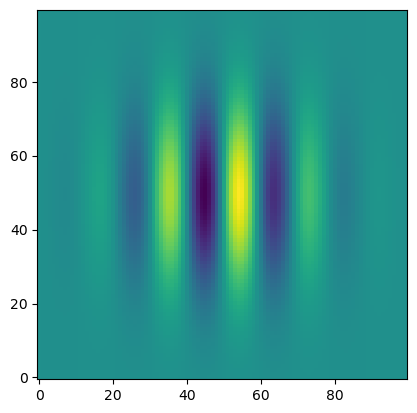

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Let's first generate some data
x=np.linspace(-2,2,100)
y=x
xx,yy=np.meshgrid(x,y)
rr=np.sqrt(xx**2+yy**2)
ff=np.exp(-0.5*(rr/0.7)**2)*np.sin(xx*8)

# Now let's store this in an HDF5 file
with h5py.File("test.h5","w") as f:
    f.create_dataset("xx",data=xx)
    f.create_dataset("yy",data=yy)
    f.create_dataset("ff",data=ff)
    
# Now let's read this HDF5 file again, to see if it works
with h5py.File("test.h5","r") as f:
    new_xx = f["xx"][:].copy()
    new_yy = f["yy"][:].copy()
    new_ff = f["ff"][:].copy()

# Now plot this
plt.imshow(new_ff,origin='lower')

## Exercise 


Open the world map file discussed earlier
    
Extract the coastlines of: America, Eurasia and Africa
    
Try to save and restore the coastlines using np.save and pickle.
   
(Hint: just use a simple lower and upper limit for latitude and longitude - you don't have to be accurate)
    
Finally, write the datasets in hdf5 format to disk and try to open the result and plot Africa


In [ ]:
# Your program here

Bayesian statistics and Markov Chain Monte Carlo (MCMC)
-------------------------------------------------------------------

MCMC is particularly common when analyzing data and quantifying the accuracy of measurements but also when you want to Monte Carlo simulate a process by **drawing random numbers from a complicated probability distribution**.

In the alternative first problem sheet and artificial language was used as an example for a Markov chain. A **Markov chain** is a stochastic process that generates a new random number only based on the immediate predecessor. If the letter ``a`` appears in a word, there is a certain probability for each letter to appear and ``n`` would be the most likely case. Based on that probability a new letter can be inserted into the chain. The next chain element will only depend on that new letter.



The idea behind Bayesian statistics is to exploit prior knowledge that is given as an additional probability distribution when interpreting data. In practice, one modifies the logarithmic likelihood by adding an extra term. That means, when there is not a sufficient number of datapoints (e.g. you have 1 measurement and want to determine slope and intercept with just one parameter) a prior distribution **will still give you an answer!**. 

$${\displaystyle P(Hypothesis\mid Data)={\frac {P(Data \mid Hypothesis)\cdot P(Hypothesis)}{P(Data)}}} $$ 

Hypothesis (i.e. prior information) must not use the same source of information!

Moreover, when you are fitting and there are multiple local minima but you know that some are a priori less likely, for instance because they violate energy conservation, you can provide and exploit that extra information. If you have many, information carrying datapoints your prior should not affect your fit because all other data outweig them. That's important to bear in mind.

## EMCEE - an MCMC implementation

The basic idea behind the so-called Markov Chain Monte Carlo is simple. Randomly walk through a given parameter space with steps proposed by a random generator. A new step is accepted with a certain probability, e.g. based on the likelihood ratio. Statisticians have shown for us that the resulting samples are coming from the distribution we are interested in and that was used to accept or reject the chain elements when we follow a certain procedure of accepting or rejecting a step.

The method can be rather slow and that's why it is often only used after a fit with a fast optimizer gave a reasonable answer. In that sense, MCMC is for sampling at the end. Of course, one could start a chain far away from the global optimum and let the proposal function explore the parameter space. One just needs enough time for that.
One of the standard packages implements the MCMC approach is the EMCEE package on: http://dfm.io/emcee/current/#

Because it is such an important tool, we are going to look deeper into the example provided on the aformentioned page. We are looking again into fitting a single line to some data. But before we can do that, we need to install the emcee package and the corner package on our machines. On your own anaconda installation you can install it using the command line (even under windows) via "pip install emcee" where emcee is the package name. 

The following example from the emcee webpage shows us again, how to use synthetic data. There is a second reason why we want to discuss the corresponding example - it illustrates that our reported uncertainties can be ``wrong`` or at least incomplete. For addressing that issue, one introduces a noise model which rescales the uncertainties and an appropriately chosen noise model is part of our model.

In [ ]:
import numpy as np
import emcee
# Choose the "true" parameters.
m_true = -0.95555
b_true = 4.2222
f_true = 0.57777

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [ ]:
#the EMCEE package requires a suitably defined likelihood
#and this is one of the most important jobs of the modeller
#you need to get that right and understand what you are doing

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b  # HERE IS WHERE YOUR MODEL IS DEFINED (CHANGE THIS AT WILL)
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

As mentioned before, a sampler is not very good (=fast) at finding the global optimum quickly. We are supporting that effort by running a conventional fitter that just looks for the steepest descent or that accepts only the best steps. 

In [ ]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print(result)

In order to exploit the aforementioned extra information we define the log prior:

In [ ]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

The total probability is the sum of both terms. NB: we are minimizing the negative logarithmic likelihood, i.e. we find the maximum likelihood. The sign needs to be defined as shown above (for emcee). Running the sampler gives us a probability distribution of our estimated parameters, the uncertainties and also the parameter for our modified noise model.

In [ ]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [ ]:
#some setup required for the random walk (in this example we only use a very small number of walkers)
ndim, nwalkers = 3, 50
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

To make nice plots of the likelihood distribution functions, and the correlations between the parameters, you can use the `corner` library. On your own laptop, install it with `pip install corner`. 

In [ ]:
import corner
print(np.mean(samples[:,0]),np.std(samples[:,0]),m_true)
print(np.mean(samples[:,1]),np.std(samples[:,1]),b_true)
print(np.mean(np.exp(samples[:,2])),np.std(np.exp(samples[:,2])),f_true)
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.show()

## Exercise 

Repeat the last steps and try to MCMC-analyze the simulated line without (!) rescaled uncertainty
    
Try to analyze a parabola with parameters 0.5, 1.0, 2.0 for a0+a1*x+a2*x*x and 3.0 and with the same noise model as before for the rescaled uncertainty. 

In [ ]:
# Your code here